test change

# Flatiron Phase 4 Project

## Aaron Galbraith

### Submitted: 

## Contents

- **[Business Understanding](#Business-Understanding)<br>**
- **[Data Understanding](#Data-Understanding)**<br>
- **[Data Preparation](#Data-Preparation)**<br>
- **[Exploration](#Exploration)**<br>
- **[Modeling](#Modeling)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**

# Business Understanding

Apple launched the iPad 2 on March 11, 2011, the same day that the 2011 SXSW Festival began in Austin, TX. Apple also launched a pop-up store in Austin specifically to sell these and other products to the swell of crowds who attended the festival. Apple product launches for their lines of iPods, iPhones, and iPads were a very big deal at the time, and much media coverage was devoted to the frenzy that accompanied each launch, e.g. Apple customers eagerly waiting in long lines for the product on the first day it was available for sale.\*

Following the festival, Apple wished to gain insight into how its presence at the festival had been received. Tweets with the hashtag #sxsw were collected and tagged according to what sentiment they expressed and which if any tech brands or products (limited to apple and google) were mentioned. Apple wanted to know what it could learn not only from its own festival presence but also from Google's presence at the same festival.

\*Little of this information accompanied the dataset. Every single tweet contained the hashtag #sxsw, and a frequency analysis of the tweets indicated they took place in 2011. Further research yielded websites such as https://techcrunch.com/2011/03/10/ipad-2-sxsw/ and https://googleblog.blogspot.com/2011/03/google-at-sxsw-2011-austin-here-we-come.html, which provided helpful details about the activities of Apple and Google at the 2011 SXSW Festival.

# Data Understanding

## Import files

Here we'll import all the tools we'll need.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize
from operator import itemgetter
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from nltk import TweetTokenizer
import string
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Load and briefly explore data set

In [2]:
# read csv into dataframe
df = pd.read_csv('../data/tweets.csv', encoding='latin-1')
# show overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
# show row and column counts
df.shape

(9093, 3)

In [4]:
# show how many unique values for each feature
df.nunique()

tweet_text                                            9065
emotion_in_tweet_is_directed_at                          9
is_there_an_emotion_directed_at_a_brand_or_product       4
dtype: int64

In [5]:
# show value counts for one feature
df.emotion_in_tweet_is_directed_at.value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [6]:
# show normalized value counts for one feature
round(df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True),2)

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    0.59
Positive emotion                      0.33
Negative emotion                      0.06
I can't tell                          0.02
Name: proportion, dtype: float64

In [7]:
# show breakdown of sentiment labels for tweets that have no product or brand identified
round(df[df.emotion_in_tweet_is_directed_at.isna()] \
.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True),2)

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    0.91
Positive emotion                      0.05
I can't tell                          0.03
Negative emotion                      0.01
Name: proportion, dtype: float64

In [8]:
df[(df.is_there_an_emotion_directed_at_a_brand_or_product != 'No emotion toward brand or product') &
   (df.emotion_in_tweet_is_directed_at.isna())
  ].tweet_text

46      Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...
64      Again? RT @mention Line at the Apple store is ...
68      Boooo! RT @mention Flipboard is developing an ...
90      Thanks to @mention for publishing the news of ...
102     ÛÏ@mention &quot;Apple has opened a pop-up st...
                              ...                        
9043    Hey is anyone doing #sxsw signing up for the g...
9049    @mention you can buy my used iPad and I'll pic...
9052    @mention You could buy a new iPad 2 tmrw at th...
9054    Guys, if you ever plan on attending #SXSW, you...
9058    &quot;Do you know what Apple is really good at...
Name: tweet_text, Length: 504, dtype: object

## Summary of data

There are 9,093 records and three features. As there are only 9,065 unique tweets, it appears that there are some duplicates.

A little more than one third (3,291) of the tweets are identified as being directed at a particular product or brand associated with either Google or Apple, while the majority do not identify a product or brand.

Relatively few records have been identified as having a negative or "I can't tell" emotion.

For the 5,802 records that don't identify a product or brand, about 9% of them were identified as having something other than "no emotion". Upon investigation of these, it appears that some of them mention "Apple" or "iPad" after all, so evidently some tweets have not been successfully associated with a product or brand.

# Data Preparation

## Renaming features

The column names are a bit cumbersome, so we'll give them new names that are easier to deal with.

In [9]:
# rename columns
df.rename(columns={'tweet_text': 'text',
                   'emotion_in_tweet_is_directed_at': 'brand',
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'},
          inplace = True)

## Missing values

In [10]:
# show records with missing text
df[df.text.isna()]

,text,brand,sentiment
6,NaN,NaN,No emotion toward brand or product


We can't do anything with a record whose text is missing, so we'll drop it.

In [11]:
# drop records with missing text values
df.dropna(subset=['text'], inplace=True)

## Edit values

As these tasks may increase the number of duplicate records, we should perform them before we look for those duplicates.

### Lower case

It's not likely that we'll lose anything important by shifting all the text to lower case, especially given the nature of tweeting.

In [12]:
# shift all text to lower case
df['text'] = df['text'].str.lower()

### Rename sentiments

The sentiment labels could be more succinct. We'll change them.

In [13]:
sentiment_rename = {
    "No emotion toward brand or product": "neutral",
    "Positive emotion": "positive",
    "Negative emotion": "negative",
    "I can't tell": "unknown"
}

df.sentiment = df.sentiment.apply(lambda x: sentiment_rename[x])

### Merge brand labels

In [14]:
# show breakdown of brand before merging
df.brand.value_counts()

brand
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [15]:
# assign either apple or google label and fill in missing values with other
df['brand'].replace(['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'], 'apple',
                     inplace=True)
df['brand'].replace(['Google', 'Other Google product or service', 'Android App', 'Android'], 'google',
                     inplace=True)
df['brand'].fillna('other',
                    inplace=True)

In [16]:
# show breakdown of brand after merging
df.brand.value_counts()

brand
other     5801
apple     2409
google     882
Name: count, dtype: int64

## Detect missing brand labels

As noted earlier, we suspect many of the tweets labeled "other" actually refer to a certain product or brand. We'll use some helpful keywords to reclassify some of the tweets that are not yet associated with either brand.

In the event that some tweets happen to mention both brands, we'll make a label for "both", and we'll label everything else "neither".

In [17]:
# make key word lists for apple and google
apple_words = ['ipad', 'apple', 'iphone', 'itunes', 'ipad2']
google_words = ['google', 'android', 'blogger', 'marissa', 'mayer', 'sketchup', 'h4ckers', 'youtube']

In [18]:
# make a function that relabels brand values by finding what keywords are mentioned in the text
def brand_fix(text, brand):
    # only relabel records that do not have one of the two brands already associated
    if brand != 'other':
        return brand
    else:
        apple, google = False, False
        # look for apple keyword
        for word in apple_words:
            if word in text:
                apple = True
                break
        # look for google keyword
        for word in google_words:
            if word in text:
                google = True
                break

        # return correct new label
        if apple & ~google:
            return 'apple'
        elif google & ~apple:
            return 'google'
        elif apple & google:
            return 'both'
        else:
            return 'neither'

In [19]:
# run above function to relabel brand values
df['brand'] = df.apply(lambda x: brand_fix(x.text, x.brand), axis=1)
# show breakdown of brand after running function
df.brand.value_counts()

brand
apple      5395
google     2831
neither     677
both        189
Name: count, dtype: int64

We were able to label a vast majority of the unassociated tweets with a brand that the tweet mentions.

# CONSIDER REVISITING "NEITHER" AND "BOTH" DEPENDING ON BUSINESS PROBLEM

## Duplicates

Now we'll address duplicated tweets

In [20]:
# show how many records are duplicates
df.duplicated().value_counts()

False    9050
True       42
Name: count, dtype: int64

In [21]:
# show how many records are duplicates
df[df.duplicated()].text.head(15)

467        before it even begins, apple wins #sxsw {link}
468        before it even begins, apple wins #sxsw {link}
664     if you're in a room full of people w/good wi-f...
775     google to launch major new social network call...
776     google to launch major new social network call...
798     google to launch major new social network call...
2231    marissa mayer: google will connect the digital...
2232    marissa mayer: google will connect the digital...
2559    counting down the days to #sxsw plus strong ca...
3810             win free ipad 2 from webdoc.com #sxsw rt
3811             win free ipad 2 from webdoc.com #sxsw rt
3812             win free ipad 2 from webdoc.com #sxsw rt
3814             win free ipad 2 from webdoc.com #sxsw rt
3950    really enjoying the changes in gowalla 3.0 for...
3962    #sxsw is just starting, #ctia is around the co...
Name: text, dtype: object

It could be worth keeping some duplicates if it seemed like two tweets were coincidentally identical. For example, two people might have tweeted "apple sucks", and in that event the fact that this happened twice might be worth noting.

From a glance at some of the duplicated records, however, these look more like errors or at least tweets that have simply been copied and pasted. We'll drop the duplicated records.

In [22]:
# drop duplicate records
df.drop_duplicates(inplace=True)

Now let's check whether any duplicated *text* records remain.

In [23]:
# show how many records are duplicates for the text value only
df.duplicated(subset=['text']).value_counts()

False    9047
True        3
Name: count, dtype: int64

Curiously, a few records are identified as duplicate text values that evidently have different values for other features. Let's see if those records differ on sentiment identification. (It's less important whether they differ on brand identification.)

In [24]:
# show sentiment identification for groups of duplicated tweets
for i, index in enumerate(df[df.duplicated(subset=['text'])].index):
    print(
        'duplicate group', i+1, '\n',
        df.loc[index].text, '\n\n',
        df[df.text == df.loc[index].text].sentiment.value_counts(),
        '\n\n- - - -\n'
    )

duplicate group 1 
 win free ipad 2 from webdoc.com #sxsw rt 

 sentiment
neutral     1
positive    1
Name: count, dtype: int64 

- - - -

duplicate group 2 
 rt @mention marissa mayer: google will connect the digital &amp; physical worlds through mobile - {link} #sxsw 

 sentiment
positive    1
neutral     1
Name: count, dtype: int64 

- - - -

duplicate group 3 
 rt @mention rt @mention it's not a rumor: apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {link} 

 sentiment
positive    1
neutral     1
Name: count, dtype: int64 

- - - -



Each duplicated tweet has been labeled once as positive and once as nonpositive. It seems fair to keep the positive labels for each of these.

In [25]:
# iterate over records listed as duplicates
for i in df[df.duplicated(subset=['text'])].index:
    # drop any records whose text matches a particular duplicate AND is labeled nonpositive
    df.drop(df[ (df.text == df.loc[i].text) & (df.sentiment == 0) ].index, inplace=True)

## Begin NLP

Now that we have the data set we want to work with, we'll use natural language processing techniques to help us analyze it.

First we'll create a feature with a list of lemmatized tokens from each tweet. We'll use a tokenizer that is specifically designed to parse tweets. We'll also get rid of the hashtags in front of terms.

In [26]:
# make tokenizer
tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True
)

# make lemmatizer
lemmatizer = WordNetLemmatizer()

# create function that transforms a text string into a list of lemmatized tokens
def tokens_lem(text):
    tokens = tokenizer.tokenize(text)
    tokens_lem = [lemmatizer.lemmatize(word) for word in tokens]

    for i in range(len(tokens_lem)):
        # delete hashtags
        if tokens_lem[i].startswith('#'):
            tokens_lem[i] = tokens_lem[i][1:]
    return tokens_lem

In [27]:
# create column of lists of lemmatized tokens
df['tokens_lem'] = df['text'].apply(lambda x: tokens_lem(x))

In [28]:
df.head()

,text,brand,sentiment,tokens_lem
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,apple,negative,"[., i, have, a, 3g, iphone, ., after, 3, hr, t..."
1,@jessedee know about @fludapp ? awesome ipad/i...,apple,positive,"[know, about, ?, awesome, ipad, /, iphone, app..."
2,@swonderlin can not wait for #ipad 2 also. the...,apple,positive,"[can, not, wait, for, ipad, 2, also, ., they, ..."
3,@sxsw i hope this year's festival isn't as cra...,apple,negative,"[i, hope, this, year's, festival, isn't, a, cr..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,google,positive,"[great, stuff, on, fri, sxsw, :, marissa, maye..."


We'll clearly have to do some work to get rid of stop words. First let's look at the corpus of words we have and find the most frequently occurring ones.

In [29]:
# make a function that takes a column from a dataframe (possibly subject to conditions)
# and returns a frequency distribution of the words from its records
def corpus_freq_dist(df_column):
    corpus = df_column.explode()
    return FreqDist(corpus)

In [30]:
corpus_freq_dist(df.tokens_lem).most_common(15)

[('sxsw', 9553),
 ('.', 5890),
 ('the', 4414),
 ('link', 4294),
 ('}', 4268),
 ('{', 4265),
 ('to', 3573),
 (',', 3512),
 ('at', 3097),
 ('rt', 2937),
 ('ipad', 2667),
 ('a', 2546),
 ('for', 2542),
 ('google', 2436),
 ('!', 2359)]

In addition to punctuation characters, some twitter-specific terms appear here, and of course sxsw. Let's start a stopwords list and put it to use.

In [31]:
# obtain the standard list of stopwords
nltk.download('stopwords')
stop_list = stopwords.words('english')
# add to this list some twitter-specific terms
stop_list.extend(['sxsw', 'link', 'rt'])
# add punctuation characters
for char in string.punctuation:
    stop_list.append(char)

# make a function to use together with the tokens_lem function to remove stopwords from the token lists
def stop(word_list):
    stopped_words = []
    for word in word_list:
        if word not in stop_list:
            stopped_words.append(word)
    return stopped_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stubbletrouble/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# create column of lists of lemmatized tokens
df['tokens_lem'] = df['text'].apply(lambda x: stop(tokens_lem(x)))

In [33]:
corpus_freq_dist(df.tokens_lem).most_common(15)

[('ipad', 2667),
 ('google', 2436),
 ('apple', 2223),
 ('iphone', 1573),
 ('store', 1516),
 ('2', 1367),
 ('new', 1078),
 ('austin', 954),
 ('app', 819),
 ('\x89', 685),
 ('launch', 678),
 ('...', 639),
 ('social', 635),
 ('android', 588),
 ('circle', 578)]

This looks better. It seems we've still got a few nonsense terms, though. Let's try to find the most frequently occurring tokens that are not alphanumeric.

In [34]:
corpus_nonalpha = []
for word in df.tokens_lem.explode():
    if str(word).isalpha() == False:
        corpus_nonalpha.append(word)

corpus_nonalpha_freq_dist = FreqDist(corpus_nonalpha)

corpus_nonalpha_freq_dist.most_common(15)

[('2', 1367),
 ('\x89', 685),
 ('...', 639),
 ('pop-up', 422),
 ('ipad2', 294),
 ("i'm", 252),
 ("google's", 182),
 ('\x9d', 152),
 ('4', 134),
 ("we're", 127),
 (':)', 120),
 ('1', 114),
 ('6th', 99),
 ("apple's", 95),
 ('5', 95)]

It seems quite probable that the "2" here is occurring when tweets include a space in the expression "ipad 2". Since this is probably happening quite a lot, we'll glue these terms together.

We can also consolidate terms like "pop-up", "popup", and "pop up", since these are all likely references to Apple's pop-up store.

We'll also add some of these unusual tokens to the stop_list.

In [35]:
# add stopwords
stop_list.extend(['\x89', '...', '\x9d'])
# reset the tokens_lem column with new stop words
df['tokens_lem'] = df['text'].apply(lambda x: stop(tokens_lem(x)))

In [60]:
# make a function to join any instance of "ipad 2" separated by a space
# note: this function is clunky and poorly written but it works
def ipad_fix(word_list):
    new_word_list = []
    for i in range(len(word_list)):
        # if the word is the first of two words that make ipad2, then add 'ipad2'
        if word_list[i] == 'ipad' and i < len(word_list) - 1 and word_list[i+1] == '2':
            new_word_list.append('ipad2')
        # if the word is the second of two words that make ipad2, then add nothing
        elif i > 0 and word_list[i-1] == 'ipad' and word_list[i] == '2':
            continue
        # in all other instances, add the word
        else:
            new_word_list.append(word_list[i])
    return new_word_list

In [63]:
# make a function to standardize "pop up", "pop-up", and "popup"
# note: this function is clunky and poorly written but it works
def popup_fix(word_list):
    new_word_list = []
    for i in range(len(word_list)):
        # if the word is the wrong one-word version, add 'pop-up'
        if word_list[i] == 'popup':
            new_word_list.append('pop-up')
        # if the word is the first of two words that make pop-up, then add 'pop-up'
        elif word_list[i] == 'pop' and i < len(word_list) - 1 and word_list[i+1] == 'up':
            new_word_list.append('pop-up')
        # if the word is the second of two words that make pop-up, then add nothing
        elif i > 0 and word_list[i-1] == 'pop' and word_list[i] == 'up':
            continue
        # in all other instances, add the word
        else:
            new_word_list.append(word_list[i])
    return new_word_list

In [64]:
# reset tokens_lem column with fixed ipad2
df['tokens_lem'] = df['tokens_lem'].apply(lambda x: ipad_fix(x))
# reset tokens_lem column with fixed popup
df['tokens_lem'] = df['tokens_lem'].apply(lambda x: popup_fix(x))

In [65]:
corpus_freq_dist(df.tokens_lem).most_common(50)

[('google', 2434),
 ('apple', 2218),
 ('iphone', 1566),
 ('store', 1512),
 ('ipad2', 1454),
 ('new', 1078),
 ('austin', 951),
 ('app', 802),
 ('launch', 678),
 ('social', 635),
 ('pop-up', 632),
 ('android', 587),
 ('circle', 578),
 ('today', 563),
 ('network', 461),
 ('get', 453),
 ('line', 434),
 ('via', 433),
 ('party', 401),
 ('free', 382),
 ('called', 349),
 ('sxswi', 339),
 ('mobile', 336),
 ('ha', 308),
 ('like', 302),
 ('time', 300),
 ('major', 293),
 ('day', 282),
 ('one', 282),
 ('map', 263),
 ('temporary', 262),
 ('w', 261),
 ('u', 258),
 ('opening', 255),
 ("i'm", 252),
 ('open', 250),
 ('wa', 238),
 ('need', 238),
 ('win', 236),
 ('go', 235),
 ('possibly', 233),
 ('come', 228),
 ('see', 228),
 ('people', 227),
 ('downtown', 223),
 ('apps', 222),
 ('great', 221),
 ('check', 220),
 ('going', 218),
 ('2', 201)]

This looks a lot better. Let's make a list of just the tokens we'll use going forward.

In [39]:
tokens = list(df.tokens_lem.explode().astype(str))

In [40]:
tokens[:15]

['3g',
 'iphone',
 '3',
 'hr',
 'tweeting',
 'rise_austin',
 'wa',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'know',
 'awesome',
 'iphone']

By the way, we can use term frequency to try to figure out what year all of this took place. We'll start around the year the first iPhone was released (2007) and include the year the dataset was created (2013).

In [41]:
# iterate over a likely timespan
for year in range(2007,2014):
    # show how frequently a given year was mentioned
    print(str(year)+':',
          corpus_freq_dist(df.tokens_lem)[str(year)]
         )

2007: 0
2008: 0
2009: 1
2010: 4
2011: 75
2012: 0
2013: 0


This strongly indicates the data comes from 2011. Particularly from the SXSW conference in Austin, TX.

# Exploration

We'll use a number of methods to see what the data can tell us.

In [42]:
non_brand_tokens = [word for word in tokens if word not in apple_words and word not in google_words]

In [43]:
tokens_apple_pos = list(df[
    (df.brand == 'apple') &
    (df.sentiment == 'negative')
].tokens_lem.explode().astype(str))

non_brand_tokens = [word for word in tokens_apple_pos if word not in apple_words and word not in google_words]

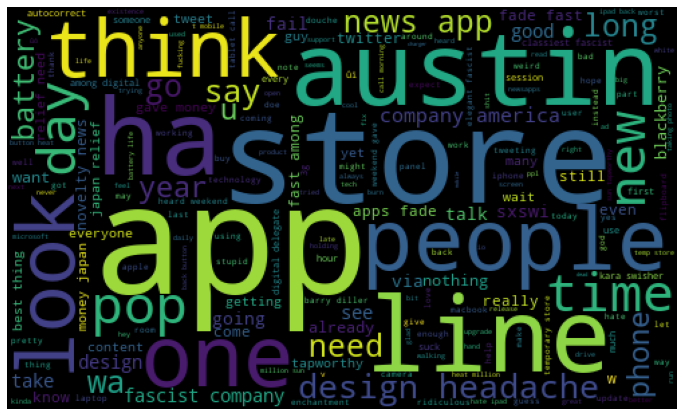

In [44]:
# instantiate wordcloud
wordcloud = WordCloud(
    width=500,
    height=300,
    collocations = True
)

# generate wordcloud
wordcloud.generate(','.join(non_brand_tokens))

# plot wordcloud

plt.figure(figsize = (12, 15), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off');

In [45]:
error

NameError: name 'error' is not defined

In [ ]:
# create feature of tokenized text
df.loc[:, 'text_tokenized'] = df['text'].apply(tokenizer.tokenize)
# make vocabulary from set of words
vocab_raw = set(df['text_tokenized'].explode())
# show size of raw vocabulary
print('Size of raw vocabulary:', len(vocab_raw))   

# CONSIDER LABELING SENTIMENT AS A BINARY

In order to reduce the class imbalance and generally simplify the work, we'll change the sentiment labels to a binary system of 1 for positive and 0 for everything else.

In [ ]:
# make sentiment binary
df['sentiment'].replace({'No emotion toward brand or product': 0,
                         'Positive emotion': 1,
                         'Negative emotion': 0,
                         "I can't tell": 0
                        }, inplace=True)

In [ ]:
# show breakdown of sentiment after merging
round(df.sentiment.value_counts(normalize=True),4)

## Train and test sets

In [ ]:
# split the data into target (sentiment) and predictor (text)
X, y = df['text'].to_frame(), df['sentiment']
# split the data into train and test sets
# set random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# REVISIT THIS

add label to X_train for research purposes .. obviously don't include this in the model

reset index to anticipate future problems ... or not reset the index???

In [ ]:
X_train.loc[:, 'sentiment'] = [y_train.loc[val] for val in X_train.index]

## Tokenize

We'll establish a token pattern that will separate each tweet into a list of tokens at least 2 letters long and ignore punctuation characters.

In [ ]:
# make tokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

We'll make a new column whose values will be the list of tokens from each text value. Then we can group these tokens/words together into a vocabulary.

In [ ]:
# create feature of tokenized text
X_train.loc[:, 'text_tokenized'] = X_train['text'].apply(tokenizer.tokenize)
# make vocabulary from set of words
vocab_raw = set(X_train['text_tokenized'].explode())
# show size of raw vocabulary
print('Size of raw vocabulary:', len(vocab_raw))   

# Modeling

## Baseline model

We'll use multinomial naive Bayes for our baseline model and feed it the 10 most common tokens.

In [ ]:
# instantiate model
baseline_model = MultinomialNB()

It will be instructive to recall the percentage of the plurality in the target feature (sentiment). Models should be evaluated in relation to this.

In [ ]:
# save this value to compare to future model crossval scores
plurality_cv = round(y_train.value_counts(normalize=True)[0],4)
# show the sentiment breakdown
round(y_train.value_counts(normalize=True),4)

Accuracy of future models should exceed the higher of these values, since we know that, at worst, a model could just predict all sentiments are "nonpositive" and achieve this accuracy score.

We'll run the first model and compare the score to this plurality.

In [ ]:
tfidf = TfidfVectorizer(
    max_features = 10
)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

baseline_cv = round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4)

print('Plurality:', plurality_cv,
      '\nBaseline: ',baseline_cv)

This did not improve on plurality at all.

Let's look at what words it was using.

In [ ]:
def plot_words(column, title):

    fig = plt.figure(figsize=(15, 5))
    fig.set_tight_layout(True)
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0, :1])
    ax2 = fig.add_subplot(gs[0, 1:2])

    axes = [ax1, ax2]

    for index, category in enumerate(y_train.unique()):

        all_words = X_train[X_train['sentiment'] == category][column].explode()
        freq_dist = FreqDist(all_words)
        top_10 = list(zip(*freq_dist.most_common(10)))
        tokens = top_10[0]
        counts = top_10[1]

        ax = axes[index]
        ax.bar(tokens, counts)

        ax.set_title(f"{title} {category}")
        ax.set_ylabel("Count")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis="x", rotation=90)

In [ ]:
plot_words('text_tokenized', 'sentiment =')

It's not surprising that these words did not yield useful results, as they're very common.

## All words model

We'll see if anything changes when we feed the model all possible tokens rather than just the 10 most common ones.

In [ ]:
tfidf = TfidfVectorizer()

X_train_vectorized = tfidf.fit_transform(X_train['text'])

all_words_cv = round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4)

print('Plurality:', plurality_cv,
      '\nBaseline: ',baseline_cv,
      '\nAll Words:',all_words_cv
     )

This did indeed improve the accuracy.

Let's see what words it scored as most useful by their tfidf scores.

In [ ]:
# create the word list from this vectorizer with new index
feature_names = np.array(tfidf.get_feature_names())
# create array of the indices of the feature_names array, ordered by tfidf score
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()
# create frequency distribution (dictionary) of 1-grams
all_words_freq_dist = FreqDist(X_train['text_tokenized'].explode())

In [ ]:
# show the words with the top 10 tfidf values, and their tfidf values
print('10 most useful words', '\n\ntfidf | frequency | word\n')
for n in range(-1,-11,-1):
    index = sorted_tfidf_index[n]
    print(
        round(X_train_vectorized.max(0).toarray()[0][index],4),
        all_words_freq_dist[feature_names[index]],
        feature_names[index]
         )
# show the words with the bottom 5 tfidf values, and their tfidf values
print('\n5 least useful words', '\n\ntfidf | frequency | word\n')
for n in range(5):
    index = sorted_tfidf_index[n]
    print(
        round(X_train_vectorized.max(0).toarray()[0][index],4),
        all_words_freq_dist[feature_names[index]],
        feature_names[index]
         )      

## Stemmed and lemmatized model

Now we'll stem and lemmatize the tokens.

In [ ]:
# instantiate a stemmer and lemmatizer
stemmer = SnowballStemmer(language="english")
lemmatizer = WordNetLemmatizer()

In [ ]:
# make a function that tokenizes, stems and lemmatizes a document
def stem_and_lemmatize_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(stemmer.stem(token)) for token in tokens]

In [ ]:
# create a column whose values are a list of stemmed and lemmatized words
X_train.loc[:, 'stem_lemma_list'] = X_train.loc[:, 'text'].apply(stem_and_lemmatize_and_tokenize)
# make vocabulary from set of words
vocab_stemmed_and_lemmatized = set(X_train['stem_lemma_list'].explode())
# compare vocabulary sizes
print('Size of raw vocabulary:                   ', len(vocab_raw),
      '\nSize of stemmed and lemmatized vocabulary:', len(vocab_stemmed_and_lemmatized)
     )

The stemmed and lemmatized vocabulary is significantly smaller. We can now investigate whether this has introduced new duplicate values for the stemmed and lemmatized text.

The feature we just created contains *lists* of lemmatized words. In order to find out whether we have duplicates, we'll need to reassemble 

In [ ]:
X_train.duplicated(subset=['stem_lemma_list']).value_counts()

# WHAT TO DO ABOUT NEW DUPLICATES?

In [ ]:
tfidf = TfidfVectorizer(
    tokenizer = stem_and_lemmatize_and_tokenize
)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

stemmed_and_lemmatized_words_cv = round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4)

print('Baseline:                    ',baseline_cv,
      '\nAll Words:                   ',all_words_cv,
      '\nStemmed and Lemmatized Words:', stemmed_and_lemmatized_words_cv
     )

It appears that feeding it lemmatized words just slightly decreased accuracy.

We know that the top 10 baseline model suffered because the most frequent words were useless. Let's experiment with a maximum document frequency.

In [ ]:
max_df_vals = np.linspace(1/100, 1, 100)
max_df_scores = []
for max_df in max_df_vals:
    tfidf = TfidfVectorizer(
        max_df = max_df
    )

    X_train_vectorized = tfidf.fit_transform(X_train['text'])

    max_df_scores.append(round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4))


In [ ]:
plt.scatter(max_df_vals, max_df_scores)
plt.ticklabel_format(axis='both', style='plain')

In [ ]:
tfidf = TfidfVectorizer(
    tokenizer = stem_and_lemmatize_and_tokenize,
    min_df = 2,
    max_df = .02
)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

stemmed_and_lemmatized_words_cv = round(cross_val_score(baseline_model, X_train_vectorized, y_train).mean(),4)

print('Plurality:                   ', plurality_cv,
      '\nStemmed and Lemmatized Words:', stemmed_and_lemmatized_words_cv
     )